# Cardiac mechanics benchmark (Problem 1)
In this demo we will cover problem 1 in the cardiac mechanics benchmark problems in [Land2015](https://royalsocietypublishing.org/doi/10.1098/rspa.2015.0641).

>Land S, Gurev V, Arens S, Augustin CM, Baron L, Blake R, Bradley C, Castro S, Crozier A, Favino M, Fastl TE. Verification of cardiac mechanics software: benchmark problems and solutions for testing active and passive material behaviour. Proc. R. Soc. A. 2015 Dec 8;471(2184):20150641.

Get z-position of point (10.0, 0.5, 1.0): 4.1549 mm


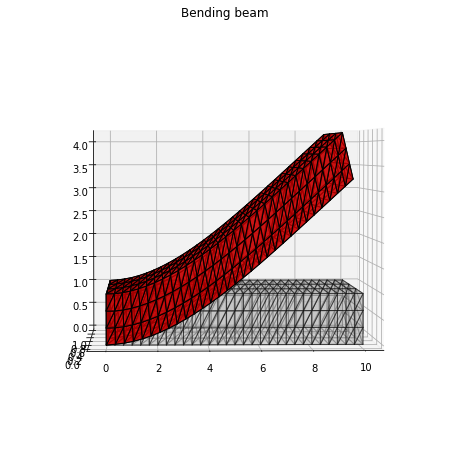

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import dolfin
import pulse
plt.rcParams["figure.figsize"] = (10,8)

# Create the Beam geometry

# Length
L = 10
# Width
W = 1

# Create mesh
mesh = dolfin.BoxMesh(dolfin.Point(0, 0, 0),
                      dolfin.Point(L, W, W),
                      30, 3, 3)

# Mark boundary subdomians
left = dolfin.CompiledSubDomain("near(x[0], side) && on_boundary", side=0)
bottom = dolfin.CompiledSubDomain("near(x[2], side) && on_boundary", side=0)

boundary_markers = dolfin.MeshFunction("size_t", mesh,
                                       mesh.topology().dim() - 1)
boundary_markers.set_all(0)

left.mark(boundary_markers, 1)
bottom.mark(boundary_markers, 2)

marker_functions = pulse.MarkerFunctions(ffun=boundary_markers)

left_marker = pulse.Marker(name='left', value=1, dimension=2)
bottom_marker = pulse.Marker(name='bottom', value=2, dimension=2)
markers = (left_marker, bottom_marker)

# Create mictrotructure
f0 = dolfin.Expression(("1.0", "0.0", "0.0"), degree=1, cell=mesh.ufl_cell())
s0 = dolfin.Expression(("0.0", "1.0", "0.0"), degree=1, cell=mesh.ufl_cell())
n0 = dolfin.Expression(("0.0", "0.0", "1.0"), degree=1, cell=mesh.ufl_cell())

# Collect the mictrotructure
microstructure = pulse.Microstructure(f0=f0, s0=s0, n0=n0)

# Create the geometry
geometry = pulse.Geometry(mesh=mesh, markers=markers,
                          marker_functions=marker_functions,
                          microstructure=microstructure)

# Create the material
material_parameters = pulse.Guccione.default_parameters()
material_parameters['CC'] = 2.0
material_parameters['bf'] = 8.0
material_parameters['bfs'] = 4.0
material_parameters['bt'] = 2.0

material = pulse.Guccione(params=material_parameters)


# Define Dirichlet boundary. Fix at the left boundary
def dirichlet_bc(W):
    V = W if W.sub(0).num_sub_spaces() == 0 else W.sub(0)
    return dolfin.DirichletBC(V, dolfin.Constant((0.0, 0.0, 0.0)), left)


# Traction at the bottom of the beam
p_bottom = dolfin.Constant(0.004)
neumann_bc = pulse.NeumannBC(traction=p_bottom,
                             marker=bottom_marker.value)

# Collect Boundary Conditions
bcs = pulse.BoundaryConditions(dirichlet=(dirichlet_bc,),
                               neumann=(neumann_bc,))

# Create problem
problem = pulse.MechanicsProblem(geometry, material, bcs)

# Solve problem
problem.solve()

# Get displacement and hydrostatic pressure
u, p = problem.state.split(deepcopy=True)

point = np.array([10.0, 0.5, 1.0])
disp = np.zeros(3)
u.eval(disp, point)

print(('Get z-position of point ({}): {:.4f} mm'
       '').format(', '.join(['{:.1f}'.format(p) for p in point]),
                  point[2] + disp[2]))

V = dolfin.VectorFunctionSpace(geometry.mesh, "CG", 1)
u_int = dolfin.interpolate(u, V)
mesh = dolfin.Mesh(geometry.mesh)
dolfin.ALE.move(mesh, u_int)
dolfin.plot(geometry.mesh, alpha=0.5, color='w', edgecolor='k')
dolfin.plot(mesh, color='r', edgecolor='k', alpha=0.7, title='Bending beam')
ax = plt.gca()
ax.view_init(elev=2, azim=-92)
ax.set_aspect('auto')
plt.show()